# Performing NER and Sentimental Analysis on Business articles of The Hindu

In [1]:
# Import necessary packages
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.text import TextCollection
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")

from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
import pandas as pd
import numpy as np

from pprint import pprint
from pymongo import MongoClient

## Fetching the articles belonging to relevant collection

In [2]:
# fetch the article collection
client = MongoClient()
db = client["TheHindu"]
col = db['business']
article = []
for item in col.find():
    article.append(item['content'])
print('Number of articles found:', len(article))

Number of articles found: 51


In [3]:
# Basic exploration
corpus = ' '.join(article)
stoplist = stopwords.words('english')
tokens = [token for token in regexp_tokenize(corpus, '\w+') if len(token) > 1 and not token.isdigit() and token.lower() not in stoplist]
freqdist = nltk.FreqDist(tokens)
print('Total number of tokens found:', len(freqdist))

Total number of tokens found: 3487


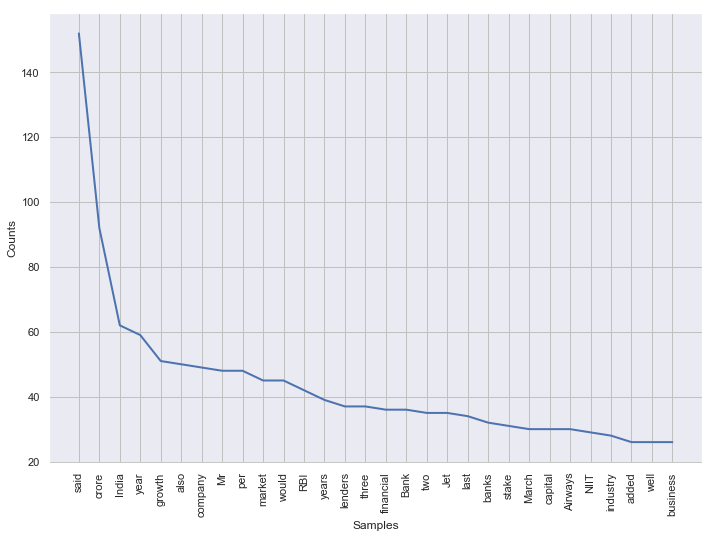

In [4]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
freqdist.plot(30)

## Demonstrating NER on a single article using Spacy

In [5]:
# perform ner on each article
print(article[0])

With new model launches and aggressive sales promotion by carmakers failing to lift consumer sentiment, the passenger vehicle (PV) segment grew 2.7% in 2018-19, the slowest pace in the last five years, according to Society of Indian Automobile Manufacturers (SIAM). The current year is also expected to be a challenging one for the industry with the general elections in the first quarter, along with transition to BS VI technology later in the year, prompting the industry body to forecast a modest growth of 3-5% in sales of passenger vehicles for 2019-20. According to SIAM data, passenger vehicle sales in the last fiscal stood at 33,77,436 units, compared to 32,88,581 units in 2017-18. The 2.7% growth follows the original forecast of 8-10%, which was later revised to 6%. This is the slowest pace of growth for the industry since 2013-14, when sales declined 6.7%. SIAM president Rajan Wadhera called for a reduction in GST to offset the increase of 10-15% across vehicle categories prices due

In [6]:
displacy.render(nlp(article[0]), jupyter=True, style='ent')

## Perfroming NER to find Named Entities in a corpus. Results are narrowed down to Persons, Organizations and GeoPolitical Entities only.

In [7]:
def getNE(text):
    ne = {}
    for x in nlp(text).ents:
        entity, label = x.text.strip(), x.label_
        if(label in ['GPE', 'PERSON', 'ORG'] and len(entity) > 1 and entity.lower() not in stoplist):
            ne[entity] = label
    return ne

In [8]:
getNE(corpus)

{'PV': 'GPE',
 'Society of Indian Automobile Manufacturers': 'ORG',
 'BS VI': 'ORG',
 'Rajan Wadhera': 'PERSON',
 'Wadhera': 'PERSON',
 'GST': 'ORG',
 'Samsung': 'ORG',
 'India': 'GPE',
 'Raju Pullan': 'PERSON',
 'Pullan': 'PERSON',
 'CRT': 'ORG',
 'AI': 'ORG',
 'IoT': 'GPE',
 'Netherlands': 'GPE',
 'Hak': 'PERSON',
 'NL': 'ORG',
 'Reliance Gas Transportation Infrastructure Ltd.': 'ORG',
 'RTGIL': 'ORG',
 'East West Pipeline Ltd.': 'ORG',
 'EWPL': 'ORG',
 'Singapore': 'GPE',
 'Biometrix Marketing Limited': 'ORG',
 'Biometrix': 'PERSON',
 'RIL': 'ORG',
 'Jamnagar': 'PERSON',
 'Mukesh Ambani': 'PERSON',
 'East West Pipeline': 'GPE',
 'Brookfield': 'PERSON',
 'India Infrastructure Trust': 'ORG',
 '₹13,000': 'PERSON',
 'The East West Pipeline Project': 'ORG',
 'China': 'GPE',
 'Russia': 'GPE',
 'Project': 'ORG',
 'Liquefied Natural Gas': 'ORG',
 'LNG': 'ORG',
 'India Ratings and Research': 'ORG',
 'Ind-Ra': 'PERSON',
 'the Ministry of Petroleum and Natural Gas': 'ORG',
 'ONGC': 'ORG',
 'th

## Performing sentimental analysis for each entity detected in all the articles. The method also involves checking upto 3 sentences ahead if the entity is found in a sentence, to include the further sentences with pronouns for the same entity.

In [9]:
# loop through the sentences containing each NER can calculate the sentiment score and average it.
def getSentimentScore(term, corpus):
    sia = SentimentIntensityAnalyzer()
    scores = []
    sentences = sent_tokenize(corpus)
    weights = [1, 0.75, 0.5, 0.25]
    for i in range(len(sentences)):
        sentence = sentences[i]
        if term in sentence:
            scores.append(sia.polarity_scores(sentence)['compound'])
            x = i+1
            while(x < len(sentences) and x-i <= 3):
                if term in sentences[x]:
                    break
                for word, tag in pos_tag(word_tokenize(sentences[x])):
                    if tag in ['PRP', 'PRP$']:
                        scores.append(sia.polarity_scores(sentences[x])['compound'] * weights[x-i])
                        break
                x += 1

    avg_sent_score = round(sum(scores)/len(scores), 5) if len(scores)>0 else 0
    return avg_sent_score

In [10]:
# organising the enities and their scores in a dictionary on the base of entity types
nes = getNE(corpus)
sent_scores = {}
for ne in nes:
    ne_tag = nes[ne]
    if ne_tag not in sent_scores:
        sent_scores[ne_tag] = []
    sent_scores[ne_tag].append((ne, getSentimentScore(ne, corpus)))

In [11]:
# Sorting the entities in increasing order of sentiment score.
for ne_tag in sent_scores:
    sent_scores[ne_tag] = sorted(sent_scores[ne_tag], key=lambda x: x[1])

In [12]:
pprint(sent_scores)

{'GPE': [('PV', -0.5994),
         ('₹11.08', -0.5423),
         ('Indonesia', -0.46625),
         ('Ranbaxy', -0.39282),
         ('₹11,756', -0.3818),
         ('Vedanta', -0.3818),
         ('Shanghai', -0.296),
         ('₹24.51', -0.1806),
         ('US', -0.10898),
         ('Brexit', -0.10504),
         ('Ethiopia', -0.09661),
         ('Singapore', -0.08705),
         ('Germany', -0.08231),
         ('Libya', -0.07529),
         ('China', -0.06257),
         ('Japan', -0.05999),
         ('₹67,190', 0.0),
         ('₹26,400', 0.0),
         ('₹32,280', 0.0),
         ('Pepe Jeans', 0.0),
         ('Bossini', 0.0),
         ('Bahrain', 0.0),
         ('Shatadru Chattopadhayay', 0.0),
         ('Vistara', 0.0048),
         ('Netherlands', 0.01072),
         ('Bengaluru', 0.016),
         ('Ranjangaon', 0.016),
         ('Dubai', 0.02573),
         ('Kenya', 0.02652),
         ('Tanzania', 0.02652),
         ('Uganda', 0.02652),
         ('Nigeria', 0.02652),
         ('Ghana', 0.

In [13]:
print('Total NE detected:')
for ne_tag in sent_scores:
    print('{}: {}'.format(ne_tag, len(sent_scores[ne_tag])))

Total NE detected:
GPE: 84
ORG: 361
PERSON: 124


## Plotting the top and bottom N entities on the basis of sentiment score rankings.

In [14]:
def plotSentScores(data, n, features):
    if n>0:
        df = pd.DataFrame(data[-n:], columns=features)
        sb.barplot(data=df, y=features[0], x=features[1], orient='h', color='green')
    elif(n<0):
        df = pd.DataFrame(data[:abs(n)], columns=features)
        sb.barplot(data=df, y=features[0], x=features[1], orient='h', color='red')

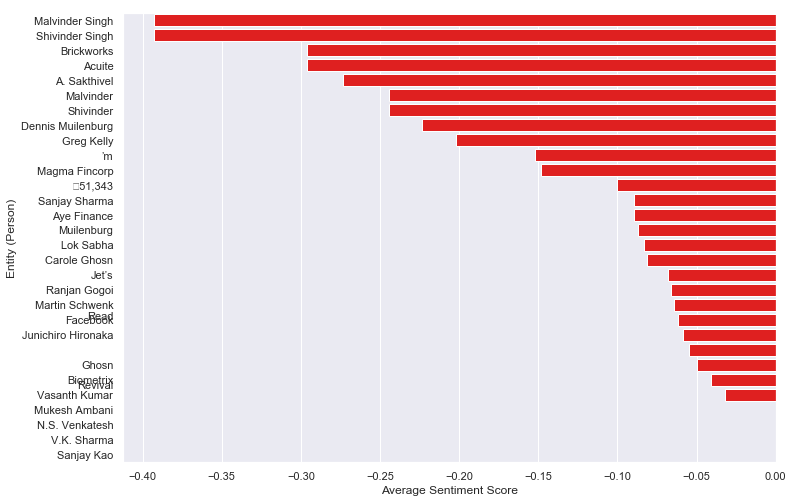

In [15]:
plotSentScores(sent_scores['PERSON'], -30, ['Entity (Person)', 'Average Sentiment Score'])

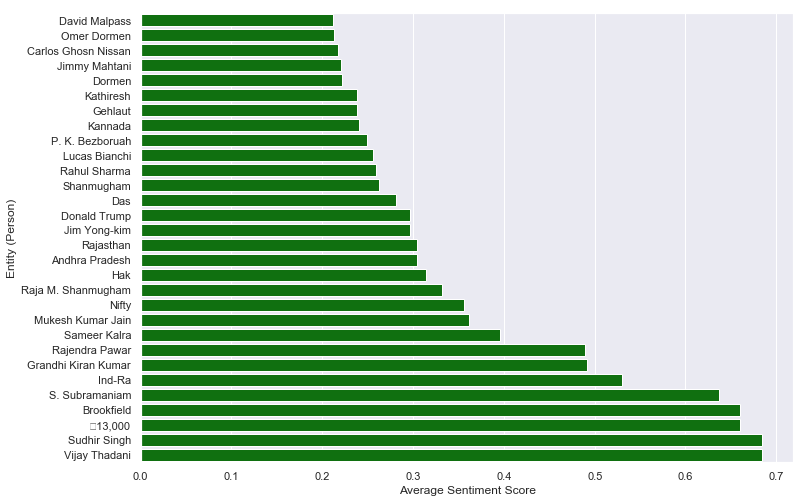

In [16]:
plotSentScores(sent_scores['PERSON'], 30, ['Entity (Person)', 'Average Sentiment Score'])

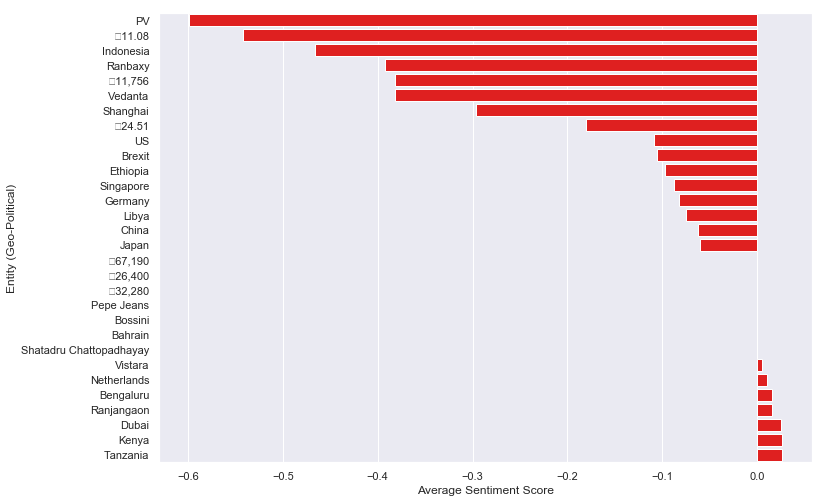

In [17]:
plotSentScores(sent_scores['GPE'], -30, ['Entity (Geo-Political)', 'Average Sentiment Score'])

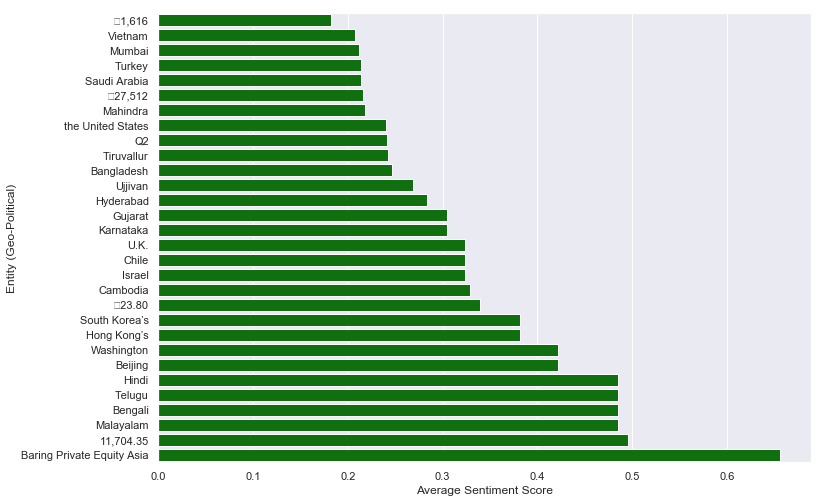

In [18]:
plotSentScores(sent_scores['GPE'], 30, ['Entity (Geo-Political)', 'Average Sentiment Score'])

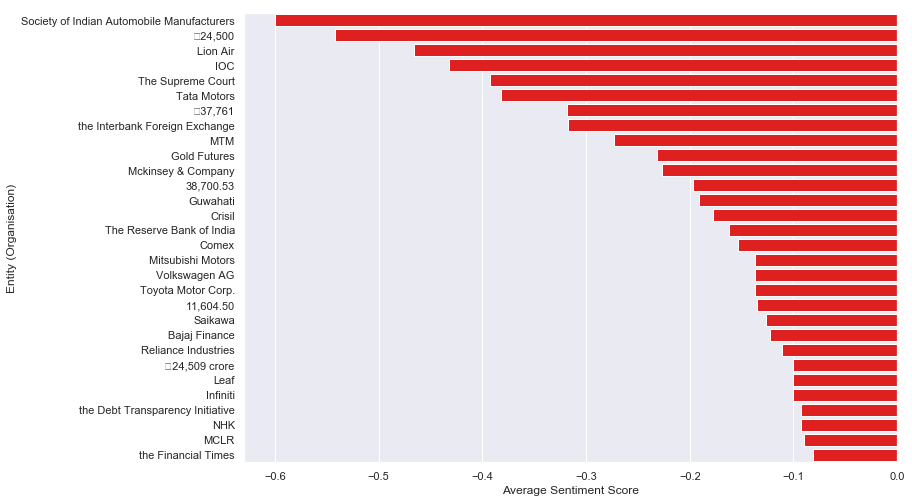

In [19]:
plotSentScores(sent_scores['ORG'], -30, ['Entity (Organisation)', 'Average Sentiment Score'])

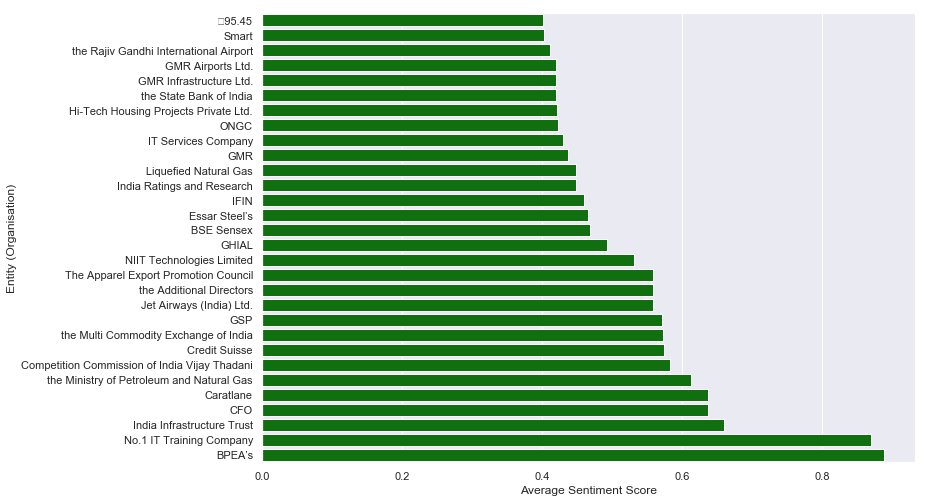

In [20]:
plotSentScores(sent_scores['ORG'], 30, ['Entity (Organisation)', 'Average Sentiment Score'])